# Vizard v2 Comprehensive Test Suite

This notebook tests all features of Vizard: stateful keywords, natural language mixing, grouping, faceting, and meta commands.

**Test Organization:**
1. Setup & Basics
2. Syntax Variations
3. Meta Commands (KEYWORDS, RESET, HELP)
4. Code Generation (FUNCTION, IMPORT)
5. Plot Types
6. Grouping & Faceting
7. Conversational Refinement
8. State Persistence
9. Dynamic Keywords

**Expected behavior:** Each test demonstrates a feature. Check generated code for correctness.

## 1. Setup & Basics

### Load necessary imports (one-time setup)
Since Vizard defaults to IMPORT false, we load libraries once here.

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
alt.renderers.enable('html')
#alt.renderers.enable('default') # Critical

fontFamily = '' # Seems better to leave empty and go with defaults
@alt.theme.register('bioinformatics_theme', enable=True)
def bioinformatics_theme():
    return alt.theme.ThemeConfig({
        'width':  600,
        'height': 400, 
        'config': {
            # Separate axis configurations
            'axisX': {
                'labelFontSize': 14,
                'titleFontSize': 18,
                'titleFontWeight': 100,
                'labelAngle': 0,
                'labelFont': fontFamily,
                'titleFont': fontFamily,  
            },
            'axisY': {
                'labelFontSize': 14,
                'titleFontSize': 18,
                'titleFontWeight': 100,
                'labelAngle': 0,
                'labelFont': fontFamily,
                'titleFont': fontFamily,  
            },
            # Title configuration
            'title': {                
                'fontSize': 25,       
                'fontWeight': 200,    
                'offset': 20,
                'font': fontFamily,        
            },
            # Legend configuration
            'legend': {
                'labelFontSize': 14,
                'titleFontSize': 18,
                'symbolSize': 600,
                'titleFontWeight': 200,
                'labelFont': fontFamily,
                'titleFont': fontFamily,   
            },
            # Text mark configuration
            'text': {
                'font': fontFamily,
                'fontWeight': 100,
                #'fontSize': 14             # Optional: set default size
            }
        }})

#### Fonts

In [3]:
fonts_to_test = [
    # Most reliable cross-platform
    'Arial',
    'Times New Roman', 
    
    # Generic fallbacks (always work)
    'sans-serif',
    'serif',
    'monospace',
    
    # Additional reliable options
    'Helvetica',        # Mac/Linux, falls back to Arial on Windows
    'Times',           # Cross-platform serif
    'Georgia',         # Web-safe serif, good readability
    
    # Office fonts (if available)
    'Calibri',         # Modern, clean sans-serif
    'Cambria',         # Modern serif designed for screen/print
]
charts = []
for font in fonts_to_test:
    chart = alt.Chart().mark_text(fontSize=14, font=font).encode(
        x=alt.value(100), y=alt.value(50), text=alt.value(f'{font}')
    ).properties(width=180, height=80, title=font[:15])
    charts.append(chart)

# Display in grid (4 columns)
alt.vconcat(*[alt.hconcat(*charts[i:i+4]) for i in range(0, len(charts), 4)])

alt.VConcatChart(...)

## Vizard

In [4]:
%load_ext cc_jupyter 


🚀 Claude Code Magic loaded!
Features:
  • Full agentic Claude Code execution
  • Cell-based code approval workflow
  • Real-time message streaming
  • Session state preservation
  • Conversation continuity across cells

Usage:
  %cc <instructions>       # Continue with additional instructions (one-line)
  %%cc <instructions>      # Continue with additional instructions (multi-line)
  %cc_new (or %ccn)        # Start fresh conversation
  %cc --help               # Show available options and usage information

Context management:
  %cc --import <file>       # Add a file to be included in initial conversation messages
  %cc --add-dir <dir>       # Add a directory to Claude's accessible directories
  %cc --mcp-config <file>   # Set path to a .mcp.json file containing MCP server configurations
  %cc --cells-to-load <num> # The number of cells to load into a new conversation (default: all for first %cc, none for %cc_new)

Output:
  %cc --model <name>       # Model to use for Claude Code (de

In [5]:
%cc VZ HELP

🧠 Claude model: claude-sonnet-4-5-20250929


💭 Claude: I'll display the Vizard help information for you.

```
# Vizard Help

## Essential Keywords (must be respected when specified):
- DATA: Data source (file, URL, variable)
- DF/DATAFRAME: polars (default) | pandas
- PLOT: bar | scatter | line | histogram | volcano | heatmap | box | etc.
- X: Column for x-axis
- Y: Column for y-axis
- COLOR: Column for coloring
- ROW: Column for row faceting
- COLUMN/COL: Column for column faceting
- SIZE: Column for size encoding
- SHAPE: Column for shape encoding
- GROUP_TYPE: grouped | stacked (for bar charts)
- ENGINE: altair (default) | matplotlib | seaborn
- FUNCTION: true/false - Generate function vs script (default: false)
- IMPORT: true/false - Include imports (default: false)

## Useful Keywords:
- TITLE: Chart title
- WIDTH: Width in pixels (default: 600)
- HEIGHT: Height in pixels (default: 400)
- OUTPUT: display (default) | save
- FILENAME: Output filename when saving

## Meta Commands:
- HELP: Show this help
- KEYWORDS/KEYS: Show current keyword state
- RESET: Clear state and restore defaults

## Syntax:
- Use CAPITALIZED keywords (case-sensitive)
- SNAKE_CASE with underscores allowed (X_TITLE, COLOR_SCHEME, etc.)
- Mix keywords and natural language freely
- Keywords don't require colons
- Optional: Start with VIZARD/VZ to explicitly signal Vizard mode
- All CAPITALIZED keywords are saved to state and persist until RESET

## Examples:
DATA mydata.csv
PLOT bar
X category Y value
COLOR blue
TITLE My Chart

or naturally:

Create a bar chart from mydata.csv showing category vs value in blue
```

📍 Claude Code Session ID: f703656b-bd52-4152-8db2-04094b28cc08


### Verify sample data exists

In [6]:
# Check sample_data.csv
data_file = Path('sample_data.csv')
print(f"Sample data exists: {data_file.exists()}")

if data_file.exists():
    df = pl.read_csv(data_file)
    print(f"\nData shape: {df.shape}")
    print(f"Columns: {df.columns}")
    display(df.head())

Sample data exists: False


## 2. Syntax Variations

Test that Vizard accepts multiple input formats: keywords-only, natural language, mixed, and with/without VIZARD trigger.

### Test 2.1: Keywords Only

In [7]:
%cc VZ DATA sample_data.csv PLOT bar X gene_name Y expression_level


🤖 Claude wants to execute code
------------------------------------------------------------
📋 To approve: Run the cell below
➡️ To continue Claude agentically afterward: Run %cc

💭 Claude: I'll create a bar chart from sample_data.csv showing gene_name vs expression_level.
⏺ Bash("cat > .vizard_state.json << 'EOF'
{
  "ENGINE": "altair",
  "DF": "polars",
  "WIDTH": 600,
  "HEIGHT": 400,
  "FUNCTION": false,
  "IMPORT": false,
  "OUTPUT": "display",
  "DATA": "sample_data.csv",
  "PLOT": "bar",
  "X": "gene_name",
  "Y": "expression_level"
}
EOF")
⏺ CreateNotebookCell


In [8]:
df = pl.read_csv('sample_data.csv')

chart = alt.Chart(df).mark_bar(color='steelblue').encode(
    x=alt.X('gene_name:N', title='Gene Name'),
    y=alt.Y('expression_level:Q', title='Expression Level')
).properties(width=600, height=400)

chart

FileNotFoundError: No such file or directory (os error 2): sample_data.csv

**Expected:** Simple bar chart with default WIDTH: 600, HEIGHT: 400, steelblue color

In [10]:
%cc X_TITLE Genes Y_TITLE Expression

✅ Continuing Claude session with execution results...

🤖 Claude wants to execute code
------------------------------------------------------------
📋 To approve: Run the cell below
➡️ To continue Claude agentically afterward: Run %cc

💭 Claude: I'll update the chart with custom axis titles. Let me update the state with these new keywords and regenerate the chart.
⏺ Write(/home/cdaniels/junk/dsllm/.vizard_state.json)
⏺ CreateNotebookCell


💭 Claude: I've updated the chart with your custom axis titles:
- X-axis: "Genes" 
- Y-axis: "Expression"

The new dynamic keywords `X_TITLE` and `Y_TITLE` have been recognized, saved to state, and applied to the chart. These will persist for future refinements until you change them or use RESET.

In [11]:
df = pl.read_csv('sample_data.csv')

chart = alt.Chart(df).mark_bar(color='steelblue').encode(
    x=alt.X('gene_name:N', title='Genes'),
    y=alt.Y('expression_level:Q', title='Expression')
).properties(width=600, height=400)

chart

alt.Chart(...)

In [13]:
%cc COLOR condition


🤖 Claude wants to execute code
------------------------------------------------------------
📋 To approve: Run the cell below
➡️ To continue Claude agentically afterward: Run %cc

💭 Claude: I'll generate the bar chart code with color encoding by the condition column.
⏺ CreateNotebookCell


💭 Claude: I've updated the state file to include `"COLOR": "condition"` and generated the bar chart code. The chart now encodes the bars by color using the `condition` column from your dataset, which will show treated vs control samples in different colors.

📍 Claude Code Session ID: 951c9ca0-bc06-42d6-a09e-b1bc5a7de49a


In [14]:
df = pl.read_csv('sample_data.csv')

chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('gene_name:N', title='Genes'),
    y=alt.Y('expression_level:Q', title='Expression'),
    color=alt.Color('condition:N', title='Condition')
).properties(width=600, height=400)

chart

alt.Chart(...)

In [16]:
%cc GROUP_TYPE grouped

✅ Continuing Claude session with execution results...

🤖 Claude wants to execute code
------------------------------------------------------------
📋 To approve: Run the cell below
➡️ To continue Claude agentically afterward: Run %cc

💭 Claude: I'll update the state file with GROUP_TYPE grouped and generate the bar chart code with grouped (side-by-side) bars.
⏺ Edit(/home/cdaniels/junk/dsllm/.vizard_state.json)
⏺ CreateNotebookCell


💭 Claude: I've updated the state file to include `"GROUP_TYPE": "grouped"` and generated the grouped bar chart code. The chart now uses `xOffset` to position the bars side-by-side for each gene, allowing you to compare treated vs control conditions directly for each gene.

In [17]:
df = pl.read_csv('sample_data.csv')

chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('gene_name:N', title='Genes'),
    xOffset=alt.XOffset('condition:N'),
    y=alt.Y('expression_level:Q', title='Expression'),
    color=alt.Color('condition:N', title='Condition')
).properties(width=600, height=400)

chart

alt.Chart(...)

In [19]:
%cc ENGINE matplot

✅ Continuing Claude session with execution results...

🤖 Claude wants to execute code
------------------------------------------------------------
📋 To approve: Run the cell below
➡️ To continue Claude agentically afterward: Run %cc

💭 Claude: I'll update the state file with ENGINE matplotlib and generate the grouped bar chart code using matplotlib.
⏺ Edit(/home/cdaniels/junk/dsllm/.vizard_state.json)
⏺ CreateNotebookCell


💭 Claude: I've updated the state file to `"ENGINE": "matplotlib"` and generated the grouped bar chart code using matplotlib. The code creates side-by-side bars for each gene, comparing treated vs control conditions, matching the grouped layout you had with Altair but now using matplotlib's plotting capabilities.

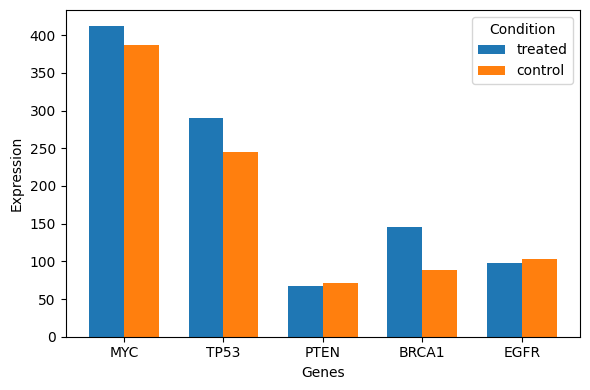

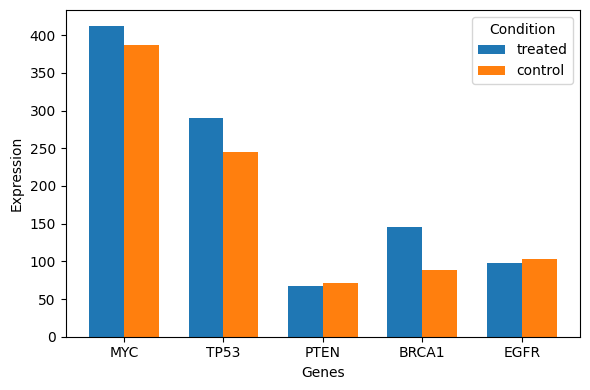

In [20]:
import matplotlib.pyplot as plt

df = pl.read_csv('sample_data.csv')

# Prepare data for grouped bar chart
genes = df['gene_name'].unique().to_list()
conditions = df['condition'].unique().to_list()

x = np.arange(len(genes))
width = 0.35

fig, ax = plt.subplots(figsize=(600/100, 400/100))

for i, condition in enumerate(conditions):
    condition_data = df.filter(pl.col('condition') == condition)
    values = [condition_data.filter(pl.col('gene_name') == gene)['expression_level'][0] 
              for gene in genes]
    ax.bar(x + i*width, values, width, label=condition)

ax.set_xlabel('Genes')
ax.set_ylabel('Expression')
ax.set_xticks(x + width/2)
ax.set_xticklabels(genes)
ax.legend(title='Condition')
plt.tight_layout()

fig

In [30]:
%cc DATA sample_data.csv DF pandas ENGINE seaborn IMPORT

✅ Continuing Claude session with execution results...

🤖 Claude wants to execute code
------------------------------------------------------------
📋 To approve: Run the cell below
➡️ To continue Claude agentically afterward: Run %cc

⏺ Bash("cat .vizard_state.json | python3 -c "
import json, sys
state = json.load(sys.stdin)
state['DATA'] = 'sample_data.csv'
state['DF'] = 'pandas'
state['ENGINE'] = 'seaborn'
state['IMPORT'] = True
json.dump(state, sys.stdout, indent=2)
" > .vizard_state.json.tmp && mv .vizard_state.json.tmp .vizard_state.json")
⏺ CreateNotebookCell


💭 Claude: I've updated the state with `IMPORT: true` and regenerated the code with all necessary imports at the top:

- `import seaborn as sns` - Seaborn for statistical visualizations
- `import pandas as pd` - Pandas for dataframe operations (per your DF setting)
- `import matplotlib.pyplot as plt` - Matplotlib's pyplot for figure control

The code now includes the full import statements as requested, making it self-contained and ready to run in a fresh environment.

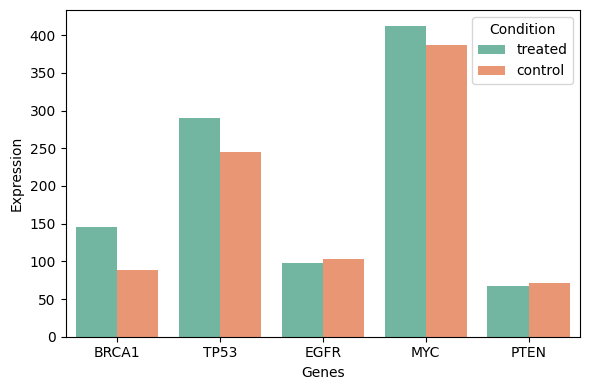

In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('sample_data.csv')

plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='gene_name', y='expression_level', hue='condition', palette='Set2')
plt.xlabel('Genes')
plt.ylabel('Expression')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

In [33]:
%cc RESET

✅ Continuing Claude session with execution results...
⏺ Bash("rm -f .vizard_state.json && cat > .vizard_state.json << 'EOF'
{
  "ENGINE": "altair",
  "DF": "polars",
  "WIDTH": 600,
  "HEIGHT": 400,
  "FUNCTION": false,
  "IMPORT": false,
  "OUTPUT": "display"
}
EOF
cat .vizard_state.json")


💭 Claude: State has been reset to defaults:
```
ENGINE: altair
DF: polars
WIDTH: 600
HEIGHT: 400
FUNCTION: false
IMPORT: false
OUTPUT: display
```

All previous keywords (DATA, PLOT, X, Y, COLOR, GROUP_TYPE, X_TITLE, Y_TITLE) have been cleared. You're ready to start a fresh figure iteration.

In [34]:
%cc KEYS

⏺ Bash("cat .vizard_state.json | python3 -c "
import json, sys
state = json.load(sys.stdin)
for key, value in state.items():
    print(f'{key}: {value}')
"")


💭 Claude: ```
ENGINE: altair
DF: polars
WIDTH: 600
HEIGHT: 400
FUNCTION: False
IMPORT: False
OUTPUT: display
```

### Test 2.2: Natural Language (Minimal Keywords)

In [8]:
%cc Create a scatter plot from sample_data.csv showing gene_name on x-axis and expression_level on y-axis

✅ Continuing Claude session with execution results...

🤖 Claude wants to execute code
------------------------------------------------------------
📋 To approve: Run the cell below
➡️ To continue Claude agentically afterward: Run %cc

💭 Claude: I'll create a scatter plot with the specifications you provided.
⏺ CreateNotebookCell


💭 Claude: I've generated a scatter plot based on your request. The code:

- Loads `sample_data.csv` using Polars
- Creates a scatter plot using `mark_point()` with a reasonable point size
- Maps `gene_name` (nominal/categorical) to the x-axis
- Maps `expression_level` (quantitative) to the y-axis
- Applies your bioinformatics theme with custom styling

Execute the cell to see the scatter plot.

In [9]:
df = pl.read_csv('sample_data.csv')

chart = alt.Chart(df).mark_point(size=100).encode(
    x=alt.X('gene_name:N', title='Gene Name'),
    y=alt.Y('expression_level:Q', title='Expression Level')
)

chart

alt.Chart(...)

**Expected:** Scatter plot inferring DATA, PLOT, X, Y from natural language

### Test 2.3: Mixed Style

In [17]:
%cc DATA sample_data.csv - create a bar chart with X gene_name and Y expression_level, COLOR_SCHEME colored by condition using a nice categorical color scheme

✅ Continuing Claude session with execution results...

🤖 Claude wants to execute code
------------------------------------------------------------
📋 To approve: Run the cell below
➡️ To continue Claude agentically afterward: Run %cc

💭 Claude: I'll create a bar chart colored by condition with a nice categorical color scheme.
⏺ Read(/home/cdaniels/junk/dsllm/.vizard_state.json)
⏺ Write(/home/cdaniels/junk/dsllm/.vizard_state.json)
⏺ CreateNotebookCell


💭 Claude: I've generated a bar chart colored by condition using the category10 color scheme. The code:

- Loads `sample_data.csv` using Polars
- Creates a bar chart with `gene_name` on the x-axis and `expression_level` on the y-axis
- Colors bars by the `condition` column using Altair's category10 scheme (provides vibrant, distinguishable categorical colors)
- Adds a legend titled "Condition"
- Uses your bioinformatics theme and default dimensions (600x400)

Execute the cell to see the color-coded bar chart.

In [18]:
df = pl.read_csv('sample_data.csv')

chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('gene_name:N', title='Gene Name'),
    y=alt.Y('expression_level:Q', title='Expression Level'),
    color=alt.Color('condition:N', 
                    scale=alt.Scale(scheme='category10'),
                    title='Condition')
).properties(width=600, height=400)

chart

alt.Chart(...)

**Expected:** Bar chart with COLOR encoding for condition, categorical color scheme applied

In [15]:
%cc RESET

✅ Continuing Claude session with execution results...
💭 Claude: I'll reset the Vizard state by deleting the existing state file and creating a fresh one with default values.
⏺ Bash("rm -f .vizard_state.json")
⏺ Write(/home/cdaniels/junk/dsllm/.vizard_state.json)


💭 Claude: Vizard state has been reset successfully. All keywords have been cleared and default values restored:

- **ENGINE**: altair
- **DF**: polars
- **WIDTH**: 600
- **HEIGHT**: 400
- **FUNCTION**: false
- **IMPORT**: false
- **OUTPUT**: display

You can now start fresh with new Vizard specifications.

### Test 2.4: Explicit VIZARD Trigger

In [16]:
%cc VIZARD make a histogram of expression_level from sample_data.csv with 20 bins COLOR False


🤖 Claude wants to execute code
------------------------------------------------------------
📋 To approve: Run the cell below
➡️ To continue Claude agentically afterward: Run %cc

💭 Claude: I'll create a histogram of expression_level with 20 bins and no color encoding.
⏺ Read(/home/cdaniels/junk/dsllm/.vizard_state.json)
⏺ Write(/home/cdaniels/junk/dsllm/.vizard_state.json)
⏺ CreateNotebookCell


💭 Claude: I've generated a histogram of expression_level with 20 bins. The code:

- Loads `sample_data.csv` using Polars
- Creates a histogram using `mark_bar()` with steelblue color (no color encoding by categories)
- Bins the `expression_level` data into 20 bins using `bin=alt.Bin(maxbins=20)`
- Uses `count()` for the y-axis to show frequency
- Sets dimensions to 600x400 (default)
- Uses your bioinformatics theme

Execute the cell to see the histogram.

In [ ]:
df = pl.read_csv('sample_data.csv')

chart = alt.Chart(df).mark_bar(color='steelblue').encode(
    x=alt.X('expression_level:Q', bin=alt.Bin(maxbins=20), title='Expression Level'),
    y=alt.Y('count()', title='Count')
).properties(width=600, height=400)

chart

**Expected:** Histogram with 20 bins, PLOT histogram inferred

### Test 2.5: Short Trigger (VZ)

In [ ]:
%cc VZ DATA sample_data.csv PLOT scatter X expression_level Y gene_name COLOR conditions

**Expected:** Scatter plot with swapped axes (quantitative x categorical)

## 3. Meta Commands

Test KEYWORDS, RESET, and HELP commands that manage state and provide information.

### Test 3.1: KEYWORDS - Show Current State

In [ ]:
%cc KEYWORDS

**Expected:** Simple list showing all keywords in current state (from previous tests)

### Test 3.2: RESET - Clear State

In [ ]:
%cc RESET

**Expected:** Confirmation that state cleared, defaults restored

### Test 3.3: KEYWORDS After RESET

In [ ]:
%cc KEYWORDS

**Expected:** Only default values shown (ENGINE: altair, DF: polars, WIDTH: 600, HEIGHT: 400, etc.)

### Test 3.4: HELP Command

In [ ]:
%cc HELP

**Expected:** Formatted help text with keyword definitions, syntax rules, examples

## 4. Code Generation Options

Test FUNCTION and IMPORT keywords that control how code is generated.

### Test 4.1: IMPORT true - Generate Imports

In [ ]:
%cc DATA sample_data.csv PLOT bar X gene_name Y expression_level IMPORT

**Expected:** Code starts with `import altair as alt` and `import polars as pl`

### Test 4.2: IMPORT false (Default) - No Imports

In [ ]:
%cc DATA sample_data.csv PLOT scatter X expression_level Y gene_name COLOR_SCHEME colored by condition using a nice categorical color scheme

**Expected:** Code starts directly with `df = pl.read_csv(...)`, no imports

### Test 4.3: FUNCTION - Generate Reusable Function

In [ ]:
%cc DATA sample_data.csv PLOT bar X gene_name Y expression_level FUNCTION IMPORT 

**Expected:** Function definition with:
- Type hints
- Docstring
- Parameters (data_file, x_col, y_col, width, height, etc.)
- Return type
- Function call at end

## 5. Plot Types

Test various plot types supported by Vizard.

### Test 5.1: Bar Chart

In [ ]:
%cc RESET
%cc DATA sample_data.csv PLOT bar X gene_name Y expression_level COLOR_SCHEME

**Expected:** Simple bar chart

### Test 5.2: Scatter Plot with Coloring

In [ ]:
%cc DATA sample_data.csv PLOT scatter X expression_level Y gene_name COLOR condition

**Expected:** Scatter with categorical color encoding by condition

### Test 5.3: Histogram

In [ ]:
%cc Create a histogram of expression_level from sample_data.csv with 15 bins COLOR_SCHEME

**Expected:** Histogram with bin parameter set to 15

### Test 5.4: Box Plot

In [ ]:
%cc_new DATA sample_data.csv PLOT box X condition Y expression_level

**Expected:** Box plot grouped by condition

## 6. Grouping & Faceting

Test GROUP_TYPE, ROW, COLUMN keywords for complex layouts.

### Test 6.1: Stacked Bar Chart

In [ ]:
%cc DATA sample_data.csv PLOT bar X gene_name Y expression_level COLOR condition GROUP_TYPE stacked

**Expected:** Bars stacked vertically, colored by condition

### Test 6.2: Grouped Bar Chart (Side-by-Side)

In [ ]:
%cc DATA sample_data.csv PLOT bar X gene_name Y expression_level COLOR condition GROUP_TYPE grouped

**Expected:** Bars side-by-side using xOffset, colored by condition

### Test 6.3: Faceted by Rows

In [ ]:
%cc DATA df PLOT scatter X expression_level Y gene_name ROW condition

**Expected:** Two scatter plots (treated, control) arranged vertically via .facet(row=...)

### Test 6.4: Faceted by Columns

In [ ]:
%cc PLOT bar X gene_name Y expression_level COLUMN condition

**Expected:** Two bar charts side-by-side via .facet(column=...)

## 7. Conversational Refinement

Test that Vizard can refine previous charts through natural language.

### Test 7.1: Initial Chart

In [ ]:
%cc RESET
%cc DATA sample_data.csv PLOT bar X gene_name Y expression_level

In [ ]:
%cc KEYS

**Expected:** Basic bar chart

### Test 7.2: Add Color

In [ ]:
%cc COLOR condition

**Expected:** Same chart now colored by condition, state updated with COLOR: condition

### Test 7.3: Natural Language Refinement

In [ ]:
%cc VZ Make the bars green and sort them by expression_level descending

**Expected:** Green bars, sorted by y-value descending (no state change, natural language only)

### Test 7.4: Update Dimensions

In [ ]:
%cc WIDTH 800 HEIGHT 500

**Expected:** Chart resized, state updated: WIDTH: 800, HEIGHT: 500

### Test 7.5: Add Title

In [ ]:
%cc TITLE Gene Expression Analysis

**Expected:** Title added, state updated: TITLE: Gene Expression Analysis

### Test 7.6: Check State After Refinements

In [ ]:
%cc KEYWORDS

**Expected:** All accumulated keywords shown: DATA, PLOT, X, Y, COLOR, WIDTH, HEIGHT, TITLE

## 8. State Persistence

Verify that state persists across cells and that RESET clears it.

### Test 8.1: Set Custom Defaults

In [ ]:
%cc RESET
%cc WIDTH 700 HEIGHT 450 DATA sample_data.csv

**Expected:** No chart generated (no PLOT specified), but state saved

### Test 8.2: Use Persisted State

In [ ]:
%cc PLOT bar X gene_name Y expression_level

**Expected:** Bar chart with WIDTH: 700, HEIGHT: 450 from previous state (not defaults)

### Test 8.3: Verify State

In [ ]:
%cc KEYS

**Expected:** Shows WIDTH: 700, HEIGHT: 450, DATA, PLOT, X, Y

### Test 8.4: Reset and Verify

In [ ]:
%cc RESET
%cc KEYS

**Expected:** Only defaults shown (WIDTH: 600, HEIGHT: 400), custom state cleared

## 9. Dynamic Keywords

Test that CAPITALIZED words not in predefined list become context-specific keywords.

### Test 9.1: Define Dynamic Keyword

In [ ]:
%cc DATA sample_data.csv PLOT scatter X expression_level Y gene_name THRESHOLD 100

**Expected:** Scatter plot generated, THRESHOLD: 100 saved to state (may not be used in initial chart)

### Test 9.2: Use Dynamic Keyword

In [ ]:
%cc Color points where expression_level > THRESHOLD in red, others in gray

**Expected:** Scatter plot with conditional coloring using THRESHOLD value from state

### Test 9.3: Verify Dynamic Keyword in State

In [ ]:
%cc KEYWORDS

**Expected:** THRESHOLD: 100 shown alongside other keywords

### Test 9.4: Update Dynamic Keyword

In [ ]:
%cc THRESHOLD 150

**Expected:** Previous chart regenerated with new threshold (150)

## 10. Spelling Tolerance

Test that common typos are recognized.

### Test 10.1: Common Typos

In [ ]:
%cc RESET
%cc DATA sample_data.csv PLOT bar X gene_name Y expression_level COLOUR blue TITEL Test Chart HIGHT 450

**Expected:** Chart generated with blue color, title "Test Chart", height 450 (typos corrected)

## Test Summary

**After running all tests, verify:**

✅ **Syntax Variations** (5 tests)
- Keywords-only, natural language, mixed, VIZARD/VZ triggers all work

✅ **Meta Commands** (4 tests)
- KEYWORDS shows state
- RESET clears state
- HELP displays documentation

✅ **Code Generation** (3 tests)
- IMPORT controls import generation
- FUNCTION generates reusable functions

✅ **Plot Types** (4 tests)
- Bar, scatter, histogram, box plots work

✅ **Grouping & Faceting** (4 tests)
- GROUP_TYPE: stacked/grouped
- ROW, COLUMN faceting

✅ **Conversational Refinement** (6 tests)
- State accumulates across cells
- Natural language modifies charts
- Keywords update state

✅ **State Persistence** (4 tests)
- State persists across cells
- RESET clears state
- Defaults vs custom state

✅ **Dynamic Keywords** (4 tests)
- CAPITALIZED words become keywords
- Saved to state
- Usable in subsequent calls

✅ **Spelling Tolerance** (1 test)
- Common typos recognized

**Total: 35 tests**

## Cleanup

In [ ]:
# Final RESET to clean state
%cc RESET